<a href="https://colab.research.google.com/github/Joyschool/2025_mirae_master/blob/main/3%EC%9D%BC%EC%B0%A8_%EB%B0%94%EC%9D%B4%EB%B8%8C%EC%BD%94%EB%94%A9_%EB%AA%A8%EB%91%90%EC%9D%98%EA%B4%91%EC%9E%A5_%EC%9B%B9%ED%81%AC%EB%A1%A4%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 웹 크롤링하여 데이터 분석하기



---



- **(코랩에서)한글폰트 설치하기**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타입 > 세션 다시 시작

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/



---



## 1.타겟 데이터
- 모두의 광장: https://modu.pcpp.go.kr/
- 데이터 크롤링 타겟:  https://modu.pcpp.go.kr/suggest-board?sortType=recent&limit=30#proposal_list_anchor

## 2.작업 순서
- 웹 크롤링하기
    1. 구글 드라이브 마운트
    2. Selenium 설치 & 내 구글 드라이브에 chromedriver 설치(최초1번)
    3. 실행준비(chrome_options 설정)
    4. 크롤링 실행
- 데이터 분석
    1. `제목` 형태소 분석하기
    2. `제목` 워드클라우드로 나타내기
    



---



## 3.웹 크롤링하기

### 3-1.구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3-2.Selenium 설치 & chromedriver 설치
(내 구글 드라이브에 chromedriver 설치, chromedriver는 최초 1회)

In [ ]:
# 파이썬 버전
!python --version

Python 3.11.13


In [ ]:
!pip show selenium

Name: selenium
Version: 4.34.2
Summary: Official Python bindings for Selenium WebDriver
Home-page: https://www.selenium.dev
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: certifi, trio, trio-websocket, typing_extensions, urllib3, websocket-client
Required-by: 


In [ ]:
# 셀레니엄 설치
!pip install selenium
!apt-get update

# (최초 1회)
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks' # 자기가 저장하고 싶은 위치
!pip install chromedriver-autoinstaller

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,508 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,269 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,574 kB]
Get:14

In [ ]:
# 크롬 드라이버 설치 확인
!which chromedriver

/usr/bin/chromedriver


In [ ]:
# 크롬 브라우저 설치 확인
!which chromium-browser

/usr/bin/chromium-browser


In [ ]:
# 셀레니엄 버전
import selenium
print(selenium.__version__)

4.34.2


### 3-3. 실행준비

- 라이브러리 가져오기

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from urllib.request import urlretrieve

import chromedriver_autoinstaller  # setup chrome options
import sys
import urllib.request
import os
import time

import pandas as pd
from datetime import datetime

- chrome_options 설정 등

In [ ]:
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

# --- 크롬 옵션 설정 ---
sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어

chrome_options.add_argument('--disable-gpu') # GPU 사용 비활성화
chrome_options.add_argument('--window-size=1920,1080') # 창 크기 설정
chrome_options.add_argument('--remote-debugging-port=9222') # 디버깅 포트 (필요 시)

chromedriver_autoinstaller.install()  # set the target URL

### 3-4. 크롤링 실행

In [ ]:
# -------- 설정값 --------
max_count = 1000  # 크롤링할 총 데이터 수
per_page = 100    # 페이지당 게시글 수
# ------------------------

print("3단계: WebDriver 초기화를 시도 중...")
try:
    driver = webdriver.Chrome(options=chrome_options)
    print("WebDriver 초기화 성공!")
except Exception as e:
    print(f"!!! 치명적인 오류: WebDriver 초기화 실패. 오류: {e} !!!")
    print("이 오류는 주로 ChromeDriver와 Chromium 버전 불일치 또는 환경 문제 때문에 발생합니다.")
    print("Colab 런타임이 최신 상태인지 확인하고 셀을 다시 실행해주세요.")
    # 오류 발생 시 스크립트 강제 종료
    exit()

titles = []
descriptions = []
dates = []
goods = []
page = 1

while len(titles) < max_count:

    url = f"https://modu.pcpp.go.kr/suggest-board?page={page}&limit={per_page}&sortType=recent#proposal_list_anchor"
    driver.get(url)
    time.sleep(3)

    # 카드형 제목 요소 추출 #proposal_list_anchor > div.suggest-list > div:nth-child(2) > div.card-body > a > p.tit > span
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-body > a > p.tit > span')
    for card in cards:
        title = card.text.strip()
        if title:
            titles.append(title)
            if len(titles) >= max_count:
                break

    # 카드형 내용 요소 추출 #proposal_list_anchor > div.suggest-list > div:nth-child(2) > div.card-body > a > p.txt
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-body > a > p.txt')
    for card in cards:
        desc = card.text.strip()
        if desc:
            descriptions.append(desc)
            if len(descriptions) >= max_count:
                break

    # 카드형 날짜 요소 추출 #proposal_list_anchor > div.suggest-list > div:nth-child(2) > div.card-btm > span
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-btm > span')
    for card in cards:
        dt = card.text.strip()
        if dt:
            dates.append(dt)
            if len(dates) >= max_count:
                break

    # 카드형 좋아요 요소 추출 #proposal_list_anchor > div.suggest-list > div:nth-child(2) > div.card-btm > div > p:nth-child(1) > span
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-btm > div > p:nth-child(1) > span')
    for card in cards:
        good = card.text.strip()
        if good:
            goods.append(good)
            if len(goods) >= max_count:
                break

    print(f"현재 페이지: {page} {len(titles)}건")
    page += 1

# 드라이버 종료
driver.quit()

# 결과 출력
print(f"총 {len(titles)}건의 제목을 추출했습니다.\n")
# for i, title in enumerate(titles, 1):
#     print(f"{i:03d}. {title}")



## 데이터 저장하기
# 리스트들을 딕셔너리로 묶기
print('4단계: Pandas표로 출력하기')
data = {
    "제목": titles,
    "등록일": dates,
    "좋아요": goods,
    "내용": descriptions,
}

# 데이터프레임으로 변환
df = pd.DataFrame(data)

# 결과 출력
display(df.head())

# 파일로 출력
print('5단계: 파일로 저장하기')
now = datetime.now()
formatted_time = now.strftime("%Y-%m-%d_%H%M")
filename = f'모두의광장_제안_{formatted_time}.csv'
df.to_csv(filename)

3단계: WebDriver 초기화를 시도 중...
WebDriver 초기화 성공!
현재 페이지: 1 100건
현재 페이지: 2 200건
현재 페이지: 3 300건
현재 페이지: 4 400건
현재 페이지: 5 500건
현재 페이지: 6 600건
현재 페이지: 7 700건
현재 페이지: 8 800건
현재 페이지: 9 900건
현재 페이지: 10 1000건
총 1000건의 제목을 추출했습니다.

4단계: Pandas표로 출력하기


,제목,등록일,좋아요,내용
0,"지극히 상식적인 민원이 발생했는데도, 민원 해결이 안 된다는 게 심각한 민원입니다!",2025.07.29,0,지극히 상식적인 민원이 발생했는데도 (ex. 범죄피해자의 보호와 구제 삶의 복구 등...
1,중학교 고등학교 수업전에 군대식pt체조 제안합니다,2025.07.29,0,요즘 체육시간도 많이 없는데 국영수만 할것면 체력키울 시간도 있었야합니다 아침마다 ...
2,강아지 목줄,2025.07.29,0,"안녕하세요 폭염속 강아지 밭지키미, 집지키미로 강아지 목줄을 당연시해 강아지들이 너..."
3,와우 미쳤다. 특히 아시아국가들은 왜 이렇게 자연을 지키지 못하지?,2025.07.29,0,자연재해를 당하고 인제 회개했으면 해
4,의료계 집단행동 사태 해결을 위한 국민 중심의 원칙 제안,2025.07.29,0,"제발 이번 의료계 집단행동 사태의 해결에 있어, 의료계의 모든 요구를 무조건적으로 ..."


5단계: 파일로 저장하기




---



## 4.데이터 분석

- 라이브러리 설치

In [ ]:
!pip install konlpy wordcloud matplotlib pandas scikit-learn > /dev/null

### 4-1.등록일별 데이터 통계
- ChatGPT가 만들어준 코드
- ChatGPT에게 코드 만들어 달라고 요청!
- 코드 수정도 ChatGPT에게 요청!

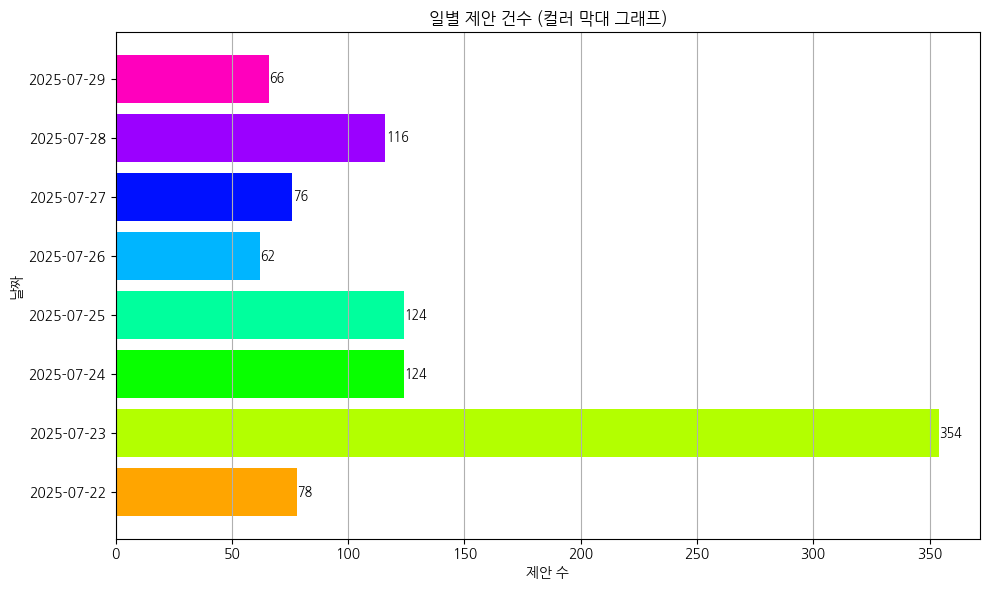

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib에서 기본 폰트로 지정
plt.rcParams['font.family'] = 'NanumGothic'



# 컬럼 이름 공백 제거
df.columns = df.columns.str.strip()

# 등록일 컬럼 찾기
date_column_candidates = [col for col in df.columns if '등록일' in col or '날짜' in col]
date_column = date_column_candidates[0] if date_column_candidates else df.columns[0]

# 날짜 컬럼을 datetime 형식으로 변환
df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

# 일자만 추출하여 그룹화
df['일자'] = df[date_column].dt.date
daily_counts = df['일자'].value_counts().sort_index()



# 색상 지정
colors = sns.color_palette("hsv", len(daily_counts))

# 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.barh(daily_counts.index.astype(str), daily_counts.values, color=colors)
plt.title('일별 제안 건수 (컬러 막대 그래프)')
plt.xlabel('제안 수')
plt.ylabel('날짜')
plt.grid(axis='x')
plt.tight_layout()

# 막대 끝에 수치 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=9)

plt.show()


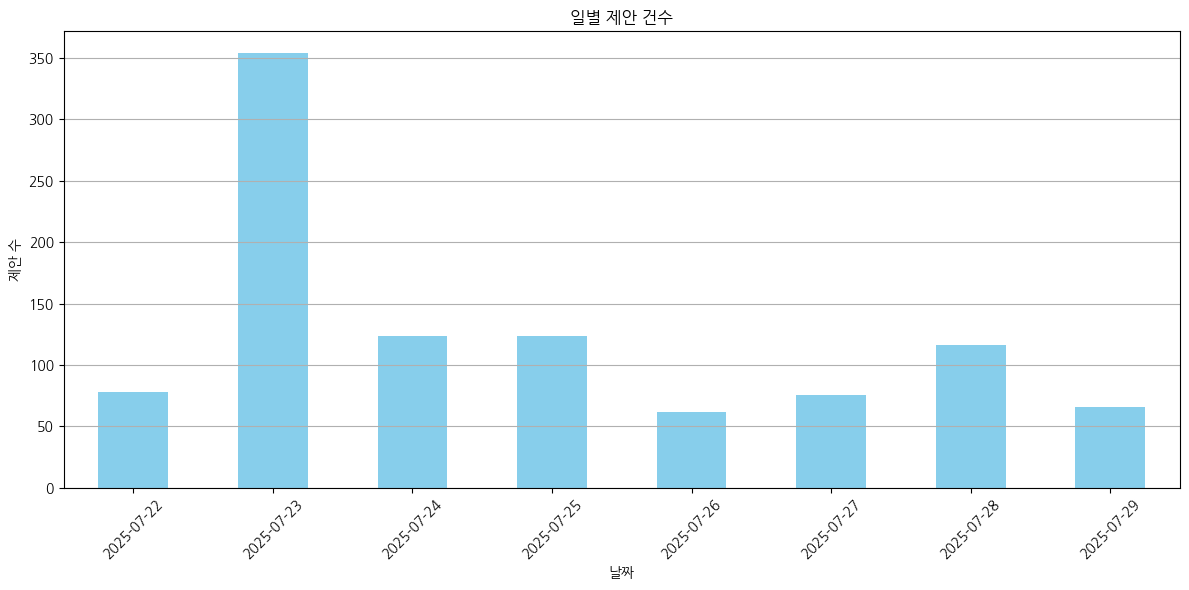

In [ ]:
# 신규 코드
# import pandas as pd
# import matplotlib.pyplot as plt

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib에서 기본 폰트로 지정
plt.rcParams['font.family'] = 'NanumGothic'


# 날짜 컬럼 확인 및 변환
df.columns = df.columns.str.strip()  # 공백 제거
date_column_candidates = [col for col in df.columns if '등록일' in col or '날짜' in col]
date_column = date_column_candidates[0] if date_column_candidates else df.columns[0]

# 날짜 형식으로 변환
df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
# 일자만 추출하여 그룹화
df['일자'] = df[date_column].dt.date

# 일별 제안 수 세기
daily_counts = df['일자'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='bar', color='skyblue')
plt.title('일별 제안 건수')
plt.xlabel('날짜')
plt.ylabel('제안 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()


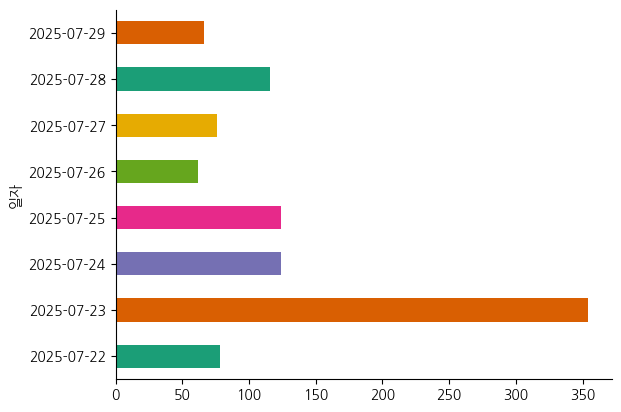

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# import seaborn as sns

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib에서 기본 폰트로 지정
plt.rcParams['font.family'] = 'NanumGothic'

df.groupby('일자').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()



### 4-2.`좋아요` 컬럼 내림차순 정렬하기

In [ ]:
# '좋아요' 컬럼 숫자형으로 변환 (쉼표 제거 → 숫자형 변환)
df['좋아요'] = df['좋아요'].astype(str).str.replace(',', '').astype(int)

# 내림차순 정렬
df_sorted = df.sort_values(by='좋아요', ascending=False)

# 상위 5개 확인
display(df_sorted.head())
# print(df_sorted.head())

,제목,등록일,좋아요,내용,일자
162,민주시민 양성 및 교육평등 실현을 위한 학교도서관 활성화,2025-07-28,903,1. 제안취지 - 학생들의 비판적 사고 능력을 키우고 교육 격차를 해소하기 위해 학...,2025-07-28
612,어린이·사회복지급식관리지원센터 예산 절감 및 효율적 운영에 관한 정책 제안입니다.,2025-07-23,748,Ⅰ. 제안배경 및 목적 어린이·사회복지급식관리지원센터(이하 센터라 함)는 2011년...,2025-07-23
999,건강한 교육 급식 환경 개선을 위해 영양교사 확대 배치가 필요합니다,2025-07-22,336,안녕하세요? 저는 현재 영양교사로 재직 중입니다. 작년 서울의 한 중학교 영양교사가...,2025-07-22
955,지체장애인교사가 대통령 및 정부에 드리는 호소문,2025-07-22,199,존경하는 대통령님과 정부 관계자 여러분께 안녕하십니까. 저는 경기도에서 17년째 아...,2025-07-22
163,주 4.5일제를 대비한 공공도서관 자원확충,2025-07-28,196,1. 제안 취지 - 공공·민간 부문을 중심으로 주 4.5일 근무제 도입이 본격적으로...,2025-07-28


### 4-3. `제목` 형태소 분석하기

- 형태소 분석 + 명사 추출

In [ ]:
# 형태소 분석 + 명사 추출
def stemming(titles):
    from konlpy.tag import Okt
    from collections import Counter

    okt = Okt()

    # 제목 전체를 하나의 텍스트로 결합
    full_text = " ".join(titles)

    # 명사 추출
    nouns = okt.nouns(full_text)

    # 불용어 제거 (예: 너무 짧은 단어)
    words = [word for word in nouns if len(word) > 1]

    # 빈도 계산
    word_counts = Counter(words)

    return word_counts


# 제목 컬럼 추출
titles = df["제목"].dropna().tolist()

# 형태소 분석 + 명사 추출
word_counts = stemming(titles)

# 딕셔너리에서 top10개 추출
top10 = dict(word_counts.most_common(10))
print(top10)


{'제안': 222, '정책': 193, '개선': 154, '전환': 86, '아파트': 84, '민간': 82, '건의': 79, '해소': 79, '임대': 77, '분양': 77}


### 4-4. 워드클라우드 시각화

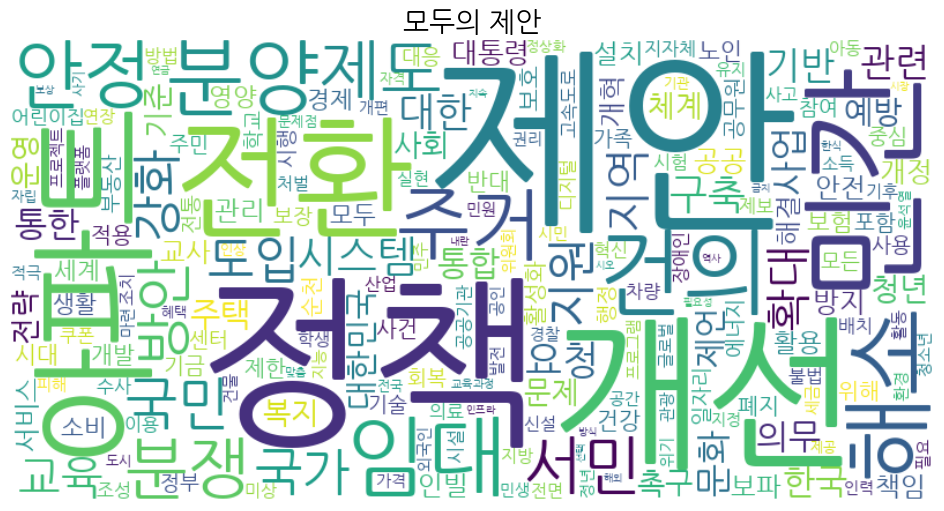

In [ ]:
# ✅ STEP 2: 워드클라우드 시각화
def display_wordcloud(word_counts):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    # 폰트 경로 설정
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

    # matplotlib에서 기본 폰트로 지정
    plt.rcParams['font.family'] = 'NanumGothic'

    # 예시 단어 빈도수 (word_counts는 실제 데이터로 대체하세요)
    # 예시:
    # from collections import Counter
    # word_counts = Counter({'청년': 20, '주택': 18, '공동체': 10})

    # 워드클라우드 생성
    wc = WordCloud(font_path=font_path, width=800, height=400, background_color='white')
    wc_img = wc.generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.imshow(wc_img, interpolation='bilinear')
    plt.axis('off')
    plt.title("모두의 제안", fontsize=20, fontweight=10)
    plt.show()

    # 이미지 파일로 저장하기
    # 폴더에 해당 이미지 파일이 있으면 다른 이름으로 이미지 파일 만들기
    imagefile = '워드클라우드.png'
    count = 1
    while os.path.exists(imagefile):
        imagefile = f'워드클라우드_{count}.png'
        count += 1
    wc.to_file(imagefile)


display_wordcloud(word_counts)



---



- 토큰화 한 결과

상위 10개 단어 (불용어 제거 후):
[('위한', np.int64(190)), ('제안', np.int64(149)), ('정책', np.int64(144)), ('개선', np.int64(111)), ('건의', np.int64(64)), ('민간임대아파트', np.int64(63)), ('분양전환', np.int64(61)), ('주거안정을', np.int64(55)), ('서민', np.int64(54)), ('해소', np.int64(54))]


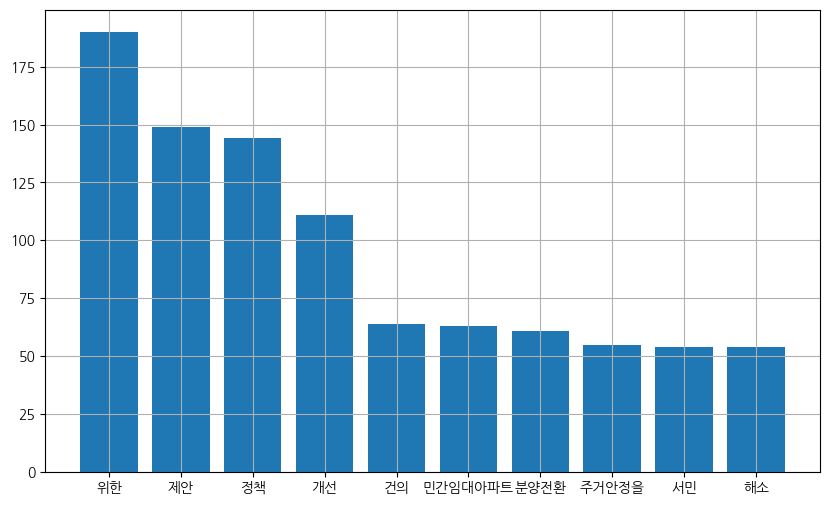

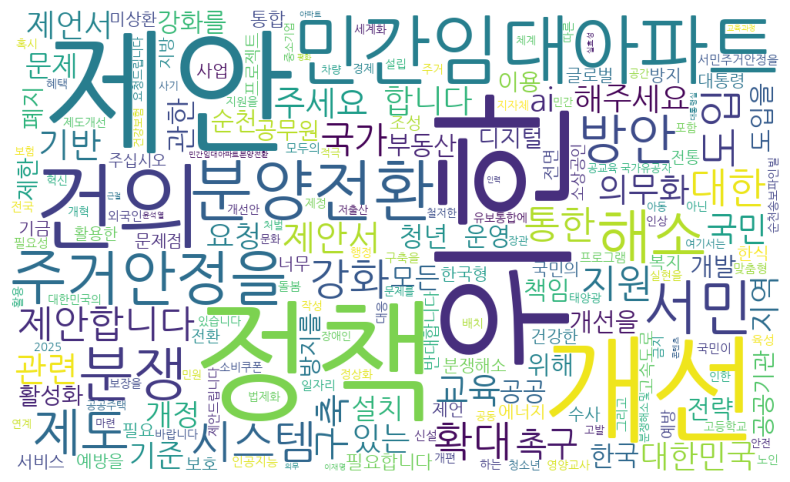

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 말뭉치를 토큰화하여 빈도수 가져오기
def get_wordTokenCount(corpus):
    import numpy as np
    from sklearn.feature_extraction.text import CountVectorizer

    # 불용어 목록 (제외할 단어들)
    # 제거목록 = ['제안', '있습니다', '현재', '배경', '안녕하세요', '있는', '저는', '정책', '합니다', '위한']
    제거목록 = []

    # 말뭉치 벡터화
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수 정렬
    idx = np.argsort(-count)
    count = count[idx]
    feature_name = np.array(vect.get_feature_names_out())[idx]

    # ❗️제거목록을 적용한 필터링
    mask = ~np.isin(feature_name, 제거목록)
    filtered_feature_name = feature_name[mask]
    filtered_count = count[mask]

    # 상위 10개 출력
    print("상위 10개 단어 (불용어 제거 후):")
    print(list(zip(filtered_feature_name, filtered_count))[:10])

    return filtered_feature_name, filtered_count


# 단어(토큰) 빈도수 막대 그래프 그리기
def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'./token_bar_graph.png')

# 워드클라우드 만들기
def make_wordcloud(feature_name, count):
    # 한글 폰트 경로를 설정
    # font_path = 'C:/Windows/Fonts/malgun.ttf'    # Windows 환경일 경우 폰트 위치
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 코랩에서 폰트 위치

    # (토큰명, 빈도수) 딕셔너리 타입으로 변환
    data = dict(zip(feature_name, count))

    # 워드클라우드로 그래프로 시각화
    wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_path)
    plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
    plt.axis("off")
    plt.show()

    # 이미지 파일로 저장하기
    imagefile = '워드클라우드.png'
    count = 1
    while os.path.exists(imagefile):
        imagefile = f'워드클라우드_{count}.png'
        count += 1
    wc.to_file(imagefile)


# 1.텍스트 말뭉치(corpus) 데이터 지정하기
corpus = df['제목'].to_list()
# print(corpus)

# 2.말뭉치를 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(corpus)

# 3.단어(토큰) 빈도수 막대 그래프 그리기(상위 10개)
draw_wordTokenCountGraph(feature_name[:10], count[:10])

# 4.워드 클라우드 만들기
make_wordcloud(feature_name, count)

### 4-5. 핵심 키워드 추출
(KeyBERT를 활용한 문맥 기반 키워드 추출)

In [ ]:
# 1단계: KeyBERT 및 관련 라이브러리 설치
!pip install -q keybert
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00


In [ ]:
# 2단계: 모델 불러오기 및 키워드 추출
from keybert import KeyBERT

# 한국어도 잘 지원되는 다국어 모델 사용
kw_model = KeyBERT(model='paraphrase-multilingual-MiniLM-L12-v2')

# 예시 문장
doc = "저는 청년 주거 문제를 해결하기 위한 정책을 제안합니다. 특히 공동체 주택에 대한 관심이 필요합니다."

# 키워드 추출
keywords = kw_model.extract_keywords(
    doc,
    keyphrase_ngram_range=(1,2),  # 1~2단어 키워드
    stop_words=['제안', '합니다', '있습니다', '필요합니다'],  # 한국어 불용어
    top_n=10
)

# 결과 출력
for i, (kw, score) in enumerate(keywords, 1):
    print(f"{i:02d}. {kw} (score: {score:.4f})")



01. 공동체 주택에 (score: 0.6211)
02. 주택에 대한 (score: 0.5883)
03. 정책을 제안합니다 (score: 0.4878)
04. 주거 문제를 (score: 0.4351)
05. 주택에 (score: 0.4319)
06. 특히 공동체 (score: 0.4169)
07. 공동체 (score: 0.4139)
08. 위한 정책을 (score: 0.3849)
09. 제안합니다 특히 (score: 0.3374)
10. 정책을 (score: 0.3280)


- 모두의 제안 건별 핵심 키워드 추출

In [ ]:
df_keyword = df.copy()
for i, doc in enumerate(df['제목'].to_list(), 0):
    print(f"\n문장 {i}: {doc}")
    keywords = kw_model.extract_keywords(doc, top_n=5, keyphrase_ngram_range=(1,2))
    for idx, (kw, score) in enumerate(keywords):
        print(f" - {kw}: {score:.4f}")
        # 컬럼에 추가
        df_keyword.loc[i, f'keyword{idx}'] =  kw
        df_keyword.loc[i, f'keyword_p{idx}'] = score

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
문장 260: 쌀 수입은 우리가 소비는 세계가(관세협상 그 후)
 - 소비는 세계가: 0.5283
 - 세계가 관세협상: 0.5025
 - 우리가 소비는: 0.4398
 - 소비는: 0.3987
 - 세계가: 0.3105

문장 261: 고등교육재정투자의 효율성·효과성 제고를 위해 ‘고등교육기금’ 제도 도입을 요청합니다.
 - 고등교육재정투자의 효율성: 0.8645
 - 고등교육기금 제도: 0.7879
 - 고등교육재정투자의: 0.7643
 - 고등교육기금: 0.7014
 - 위해 고등교육기금: 0.6020

문장 262: 국민사법권행사+국민안전생명보호권행사+국민민생생활권행사는 적법공정한 법률(강제법규조항)준수적용을 따른 선제조치이행이 필수입니다
 - 국민민생생활권행사는 적법공정한: 0.8064
 - 법률 강제법규조항: 0.7054
 - 강제법규조항: 0.6994
 - 국민사법권행사: 0.6647
 - 강제법규조항 준수적용을: 0.6484

문장 263: 제 12편 전승절 전격 참가 제안 2
 - 12편 전승절: 0.7402
 - 참가 제안: 0.7337
 - 참가: 0.6056
 - 12편: 0.5971
 - 제안: 0.5815

문장 264: 교통사고 예방을 위한 일반 운전자 안전 교육 외 추가 제안
 - 교통사고 예방을: 0.8191
 - 운전자 안전: 0.7670
 - 교통사고: 0.6922
 - 안전 교육: 0.6591
 - 일반 운전자: 0.5771

문장 265: 민생회복 지원금에 대한 제안
 - 민생회복: 0.7570
 - 민생회복 지원금에: 0.6483
 - 대한 제안: 0.4514
 - 제안: 0.4245
 - 대한: 0.3537

문장 266: 유류값이 대단히 비싸서 제주도의 물가 상승의 원흉이 되고 있습니다.
 - 물가 상승의: 0.4118
 - 대단히 비싸서: 0.3987
 - 비싸서: 0.3657
 - 물가: 0.2317
 - 제주도의 물가: 0.2193

문장 267: 

- 파일로 저장

In [ ]:
display(df_keyword.head())
df_keyword.to_csv(filename + '_keyword.csv')

,제목,등록일,좋아요,내용,일자,keyword0,keyword_p0,keyword1,keyword_p1,keyword2,keyword_p2,keyword3,keyword_p3,keyword4,keyword_p4
0,"지극히 상식적인 민원이 발생했는데도, 민원 해결이 안 된다는 게 심각한 민원입니다!",2025-07-29,0,지극히 상식적인 민원이 발생했는데도 (ex. 범죄피해자의 보호와 구제 삶의 복구 등...,2025-07-29,민원 해결이,0.5208,발생했는데도 민원,0.5160,심각한 민원입니다,0.4971,상식적인 민원이,0.4944,민원이,0.4732
1,중학교 고등학교 수업전에 군대식pt체조 제안합니다,2025-07-29,0,요즘 체육시간도 많이 없는데 국영수만 할것면 체력키울 시간도 있었야합니다 아침마다 ...,2025-07-29,고등학교 수업전에,0.7939,수업전에 군대식pt체조,0.7891,군대식pt체조 제안합니다,0.7310,중학교 고등학교,0.7189,수업전에,0.7041
2,강아지 목줄,2025-07-29,0,"안녕하세요 폭염속 강아지 밭지키미, 집지키미로 강아지 목줄을 당연시해 강아지들이 너...",2025-07-29,강아지 목줄,1.0000,강아지,0.9412,목줄,0.8169,NaN,NaN,NaN,NaN
3,와우 미쳤다. 특히 아시아국가들은 왜 이렇게 자연을 지키지 못하지?,2025-07-29,0,자연재해를 당하고 인제 회개했으면 해,2025-07-29,아시아국가들은 이렇게,0.5326,특히 아시아국가들은,0.4511,아시아국가들은,0.4424,자연을,0.3128,이렇게 자연을,0.2980
4,의료계 집단행동 사태 해결을 위한 국민 중심의 원칙 제안,2025-07-29,0,"제발 이번 의료계 집단행동 사태의 해결에 있어, 의료계의 모든 요구를 무조건적으로 ...",2025-07-29,의료계 집단행동,0.8327,의료계,0.6083,집단행동 사태,0.5301,집단행동,0.4847,국민 중심의,0.4764


### 4-6 핵심키워드 워드클라우드 표현하기

WordTop10: {'분양': 64, '전환': 64, '아파트': 39, '분쟁': 36, '민간': 35, '임대': 33, '정책': 24, '제안': 20, '국가': 18, '제도': 15}


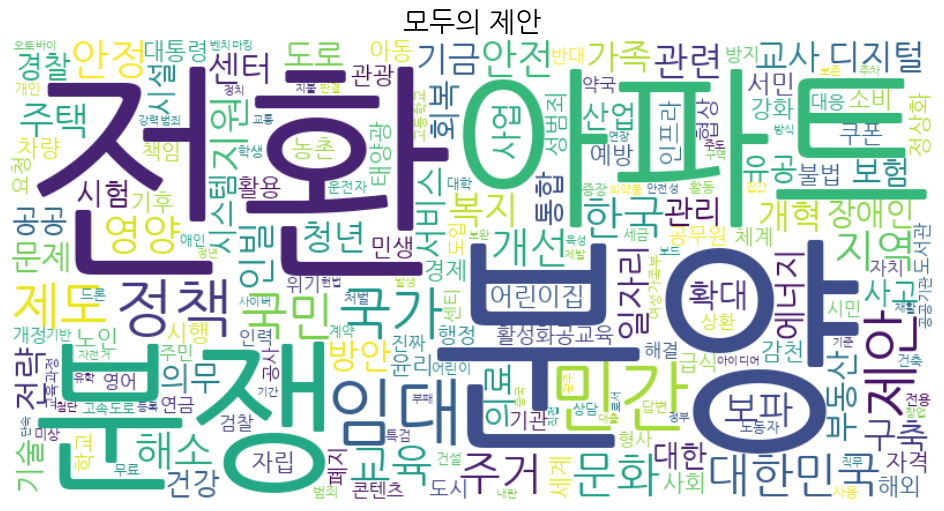

In [ ]:
# 형태소 분석 + 명사
word_counts = stemming(df_keyword['keyword1'].dropna().to_list())
print(f'WordTop10: {dict(word_counts.most_common(10))}')

# 워드클라우드 시각화
display_wordcloud(word_counts)
